In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

raw_train = pd.read_csv("/content/drive/MyDrive/raw_train.csv")

In [49]:
#date열 str에서 datetime형으로 변환
raw_train['date'] = pd.to_datetime(raw_train['date'])

In [41]:
target_year=2021
train = raw_train[raw_train['date'].dt.year<target_year]
len(train)

981

In [42]:
target_year=2021
validation = raw_train[raw_train['date'].dt.year==target_year]
len(validation)

248

In [43]:
target_year=2022
test = raw_train[raw_train['date'].dt.year==target_year]
len(test)

246

In [54]:
raw_train

,close,open,high,low,rsi,MACD_12_26,MACD_sign_12_26,hband,mavg,lband,CSI,target
date,,,,,,,,,,,,
2017-01-02,2026.16,2022.23,2031.79,2015.68,51.846817,1.534583,1.568948,2520.977931,2436.844485,2352.711040,93.3,-16.745712
2017-01-03,2043.97,2034.31,2044.07,2028.47,51.846817,1.534583,1.568948,2520.977931,2436.844485,2352.711040,93.3,0.879003
2017-01-04,2045.64,2046.29,2046.29,2040.61,51.846817,1.534583,1.568948,2520.977931,2436.844485,2352.711040,93.3,0.081704
2017-01-05,2041.95,2045.52,2046.50,2039.49,51.846817,1.534583,1.568948,2520.977931,2436.844485,2352.711040,93.3,-0.180384
2017-01-06,2049.12,2048.11,2051.84,2045.66,51.846817,1.534583,1.568948,2520.977931,2436.844485,2352.711040,93.3,0.351135
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,2313.69,2325.86,2333.08,2311.90,38.363622,-15.931807,-5.996773,2473.727635,2386.713000,2299.698365,90.2,-1.826259
2022-12-26,2317.14,2312.54,2321.92,2304.20,39.169097,-18.026966,-8.402811,2473.609437,2382.156500,2290.703563,90.2,0.149112
2022-12-27,2332.79,2327.52,2335.99,2321.48,42.819515,-18.214604,-10.365170,2467.817580,2377.126500,2286.435420,90.2,0.675402


In [45]:
raw_train['target'] = raw_train.d_ret

In [46]:
raw_train = raw_train.drop('d_ret',axis=1)

In [53]:
raw_train.set_index("date",inplace=True)

#XGBoost

In [ ]:
'''
참고: https://dining-developer.tistory.com/7
https://hwi-doc.tistory.com/entry/%EC%9D%B4%ED%95%B4%ED%95%98%EA%B3%A0-%EC%82%AC%EC%9A%A9%ED%95%98%EC%9E%90-XGBoost

'''

In [56]:
from xgboost import XGBRegressor
import numpy as np
import xgboost as xgb


X, y = raw_train.iloc[:,:-1],raw_train.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=X,label=y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=246, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=248, random_state=123)
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)


from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
# RMSE: 1.083631
# RMSE: 1.178757


# cross validation
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,'max_depth': 5, 'alpha': 10}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

print((cv_results["test-rmse-mean"]).tail(1))
# 1.183196
# 1.128603

[11:51:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 1.178757
[11:51:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:51:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:51:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
49    1.128603
Name: test-rmse-mean, dtype: float64


In [57]:
# cross validation_2
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.02,'max_depth': 5, 'alpha': 10, 'min_child_weight':3, 'colsample_bytree':0.5,}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

print((cv_results["test-rmse-mean"]).tail(1))
# 1.19683
# 1.15654

[11:52:18] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:52:18] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:52:18] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
49    1.15654
Name: test-rmse-mean, dtype: float64


In [58]:
cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
45,1.104837,0.048427,1.161372,0.128889
46,1.102354,0.048555,1.160134,0.128589
47,1.100013,0.047892,1.158644,0.128697
48,1.097372,0.047343,1.157364,0.128805
49,1.095050,0.048216,1.156540,0.128018


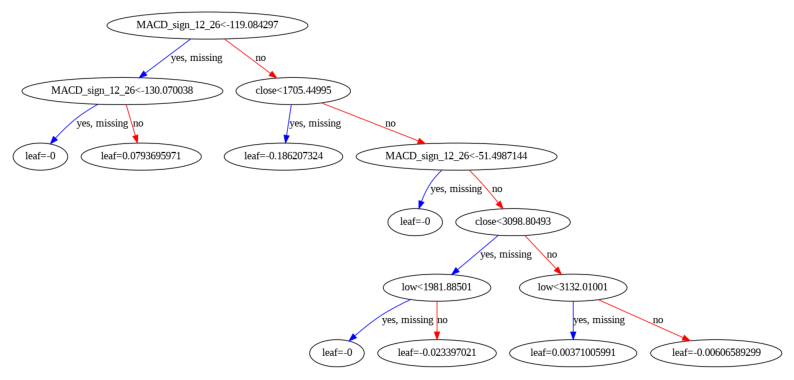

In [197]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=9)
plt.rcParams['figure.figsize'] = [40, 10]
plt.show()

In [61]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# 객체 생성, 일단은 트리 100개만 만듦
xgb_model = XGBRegressor(n_estimators=100)

# 후보 파라미터 선정
params = {'max_depth':[5,7], 'min_child_weight':[1,3], 'colsample_bytree':[0.5,0.75]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
gridcv = GridSearchCV(xgb_model, param_grid=params, cv=3)


# 파라미터 튜닝 시작
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='rmse', eval_set=[(X_test, y_test)])

#튜닝된 파라미터 출력
print(gridcv.best_params_)
# {'colsample_bytree': 0.5, 'max_depth': 5, 'min_child_weight': 3}
# {'colsample_bytree': 0.75, 'max_depth': 5, 'min_child_weight': 1}

[0]	validation_0-rmse:1.15676
[1]	validation_0-rmse:1.15113
[2]	validation_0-rmse:1.16934
[3]	validation_0-rmse:1.14908
[4]	validation_0-rmse:1.14226
[5]	validation_0-rmse:1.12725
[6]	validation_0-rmse:1.13627
[7]	validation_0-rmse:1.14387
[8]	validation_0-rmse:1.14087
[9]	validation_0-rmse:1.15032
[10]	validation_0-rmse:1.14933
[11]	validation_0-rmse:1.15473
[12]	validation_0-rmse:1.15192
[13]	validation_0-rmse:1.15342
[14]	validation_0-rmse:1.15598
[15]	validation_0-rmse:1.15962
[16]	validation_0-rmse:1.15809
[17]	validation_0-rmse:1.15819
[18]	validation_0-rmse:1.15307
[19]	validation_0-rmse:1.15686
[20]	validation_0-rmse:1.15821
[21]	validation_0-rmse:1.15678
[22]	validation_0-rmse:1.15565
[23]	validation_0-rmse:1.15637
[24]	validation_0-rmse:1.15355
[25]	validation_0-rmse:1.15335
[26]	validation_0-rmse:1.15366
[27]	validation_0-rmse:1.15460
[28]	validation_0-rmse:1.15183
[29]	validation_0-rmse:1.15001
[30]	validation_0-rmse:1.15592


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:1.15865
[32]	validation_0-rmse:1.15475
[33]	validation_0-rmse:1.15320
[34]	validation_0-rmse:1.15302
[0]	validation_0-rmse:1.19430
[1]	validation_0-rmse:1.21330
[2]	validation_0-rmse:1.22953
[3]	validation_0-rmse:1.17215
[4]	validation_0-rmse:1.13352
[5]	validation_0-rmse:1.14788
[6]	validation_0-rmse:1.16863
[7]	validation_0-rmse:1.19672
[8]	validation_0-rmse:1.19572
[9]	validation_0-rmse:1.19763
[10]	validation_0-rmse:1.20229
[11]	validation_0-rmse:1.21952
[12]	validation_0-rmse:1.21202
[13]	validation_0-rmse:1.23211
[14]	validation_0-rmse:1.24249
[15]	validation_0-rmse:1.24080
[16]	validation_0-rmse:1.23488
[17]	validation_0-rmse:1.23877
[18]	validation_0-rmse:1.23516
[19]	validation_0-rmse:1.23344
[20]	validation_0-rmse:1.23287
[21]	validation_0-rmse:1.23041
[22]	validation_0-rmse:1.22325
[23]	validation_0-rmse:1.23282
[24]	validation_0-rmse:1.23438
[25]	validation_0-rmse:1.22928
[26]	validation_0-rmse:1.23578
[27]	validation_0-rmse:1.23452
[28]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-rmse:1.22492
[33]	validation_0-rmse:1.22603
[34]	validation_0-rmse:1.22900
[0]	validation_0-rmse:1.21642
[1]	validation_0-rmse:1.15618
[2]	validation_0-rmse:1.12360
[3]	validation_0-rmse:1.11620
[4]	validation_0-rmse:1.10677
[5]	validation_0-rmse:1.10916
[6]	validation_0-rmse:1.10937
[7]	validation_0-rmse:1.11894
[8]	validation_0-rmse:1.10835
[9]	validation_0-rmse:1.10647
[10]	validation_0-rmse:1.10892
[11]	validation_0-rmse:1.10848
[12]	validation_0-rmse:1.09725
[13]	validation_0-rmse:1.10514
[14]	validation_0-rmse:1.10448
[15]	validation_0-rmse:1.10367
[16]	validation_0-rmse:1.10846
[17]	validation_0-rmse:1.10806
[18]	validation_0-rmse:1.10726
[19]	validation_0-rmse:1.10949
[20]	validation_0-rmse:1.10568
[21]	validation_0-rmse:1.09928
[22]	validation_0-rmse:1.09927
[23]	validation_0-rmse:1.10061
[24]	validation_0-rmse:1.09651
[25]	validation_0-rmse:1.09555
[26]	validation_0-rmse:1.09801
[27]	validation_0-rmse:1.10087
[28]	validation_0-rmse:1.09935
[29]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[34]	validation_0-rmse:1.10802
[35]	validation_0-rmse:1.10796
[36]	validation_0-rmse:1.10966
[37]	validation_0-rmse:1.11250
[38]	validation_0-rmse:1.11452
[39]	validation_0-rmse:1.11465
[40]	validation_0-rmse:1.11600
[41]	validation_0-rmse:1.11716
[42]	validation_0-rmse:1.11161
[43]	validation_0-rmse:1.11049
[44]	validation_0-rmse:1.10922
[45]	validation_0-rmse:1.10664
[46]	validation_0-rmse:1.10817
[47]	validation_0-rmse:1.10876
[48]	validation_0-rmse:1.10749
[49]	validation_0-rmse:1.10767
[50]	validation_0-rmse:1.10693
[51]	validation_0-rmse:1.10869
[52]	validation_0-rmse:1.10976
[53]	validation_0-rmse:1.10900
[54]	validation_0-rmse:1.10944
[55]	validation_0-rmse:1.10910
[56]	validation_0-rmse:1.10950
[57]	validation_0-rmse:1.10928
[58]	validation_0-rmse:1.11147
[0]	validation_0-rmse:1.15536
[1]	validation_0-rmse:1.15046
[2]	validation_0-rmse:1.18052
[3]	validation_0-rmse:1.16198
[4]	validation_0-rmse:1.15283
[5]	validation_0-rmse:1.14318
[6]	validation_0-rmse:1.14994
[7]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:1.17265
[32]	validation_0-rmse:1.17304
[33]	validation_0-rmse:1.17565
[34]	validation_0-rmse:1.18041
[0]	validation_0-rmse:1.17935
[1]	validation_0-rmse:1.17549
[2]	validation_0-rmse:1.17784
[3]	validation_0-rmse:1.14138
[4]	validation_0-rmse:1.14595
[5]	validation_0-rmse:1.13909
[6]	validation_0-rmse:1.15716
[7]	validation_0-rmse:1.17311
[8]	validation_0-rmse:1.17551
[9]	validation_0-rmse:1.17916
[10]	validation_0-rmse:1.18220
[11]	validation_0-rmse:1.17628
[12]	validation_0-rmse:1.16980
[13]	validation_0-rmse:1.16845
[14]	validation_0-rmse:1.18137
[15]	validation_0-rmse:1.18095
[16]	validation_0-rmse:1.17744
[17]	validation_0-rmse:1.18006
[18]	validation_0-rmse:1.18427
[19]	validation_0-rmse:1.17915
[20]	validation_0-rmse:1.17950
[21]	validation_0-rmse:1.17419
[22]	validation_0-rmse:1.18188
[23]	validation_0-rmse:1.18852
[24]	validation_0-rmse:1.18803
[25]	validation_0-rmse:1.20083
[26]	validation_0-rmse:1.18878
[27]	validation_0-rmse:1.17676
[28]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-rmse:1.18188
[31]	validation_0-rmse:1.18172
[32]	validation_0-rmse:1.18817
[33]	validation_0-rmse:1.18993
[34]	validation_0-rmse:1.19102
[0]	validation_0-rmse:1.18491
[1]	validation_0-rmse:1.20250
[2]	validation_0-rmse:1.21578
[3]	validation_0-rmse:1.20879
[4]	validation_0-rmse:1.21236
[5]	validation_0-rmse:1.22872
[6]	validation_0-rmse:1.24350
[7]	validation_0-rmse:1.25790
[8]	validation_0-rmse:1.26110
[9]	validation_0-rmse:1.26705
[10]	validation_0-rmse:1.28082
[11]	validation_0-rmse:1.27097
[12]	validation_0-rmse:1.29053
[13]	validation_0-rmse:1.29864
[14]	validation_0-rmse:1.29148
[15]	validation_0-rmse:1.29165
[16]	validation_0-rmse:1.29889
[17]	validation_0-rmse:1.29936
[18]	validation_0-rmse:1.30074
[19]	validation_0-rmse:1.30184
[20]	validation_0-rmse:1.28139
[21]	validation_0-rmse:1.28477
[22]	validation_0-rmse:1.28507
[23]	validation_0-rmse:1.29313
[24]	validation_0-rmse:1.29081
[25]	validation_0-rmse:1.29235
[26]	validation_0-rmse:1.29479


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-rmse:1.29944
[28]	validation_0-rmse:1.30373
[29]	validation_0-rmse:1.29156
[30]	validation_0-rmse:1.29754
[0]	validation_0-rmse:1.16436
[1]	validation_0-rmse:1.14976
[2]	validation_0-rmse:1.16397
[3]	validation_0-rmse:1.14351
[4]	validation_0-rmse:1.15562
[5]	validation_0-rmse:1.17026
[6]	validation_0-rmse:1.17534
[7]	validation_0-rmse:1.18715
[8]	validation_0-rmse:1.18105
[9]	validation_0-rmse:1.18193
[10]	validation_0-rmse:1.18821
[11]	validation_0-rmse:1.19216
[12]	validation_0-rmse:1.19118
[13]	validation_0-rmse:1.19806
[14]	validation_0-rmse:1.20157
[15]	validation_0-rmse:1.20127
[16]	validation_0-rmse:1.20434
[17]	validation_0-rmse:1.20475
[18]	validation_0-rmse:1.20718
[19]	validation_0-rmse:1.21109
[20]	validation_0-rmse:1.20759
[21]	validation_0-rmse:1.20905
[22]	validation_0-rmse:1.20880
[23]	validation_0-rmse:1.20935
[24]	validation_0-rmse:1.20913
[25]	validation_0-rmse:1.21250
[26]	validation_0-rmse:1.21200
[27]	validation_0-rmse:1.21226


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-rmse:1.21021
[29]	validation_0-rmse:1.21058
[30]	validation_0-rmse:1.21018
[31]	validation_0-rmse:1.21093
[32]	validation_0-rmse:1.21005
[0]	validation_0-rmse:1.19546
[1]	validation_0-rmse:1.21233
[2]	validation_0-rmse:1.23152
[3]	validation_0-rmse:1.19286
[4]	validation_0-rmse:1.17736
[5]	validation_0-rmse:1.15520
[6]	validation_0-rmse:1.16520
[7]	validation_0-rmse:1.17587
[8]	validation_0-rmse:1.18135
[9]	validation_0-rmse:1.18669
[10]	validation_0-rmse:1.17789
[11]	validation_0-rmse:1.18923
[12]	validation_0-rmse:1.17561
[13]	validation_0-rmse:1.17483
[14]	validation_0-rmse:1.18253
[15]	validation_0-rmse:1.18570
[16]	validation_0-rmse:1.18487
[17]	validation_0-rmse:1.18043
[18]	validation_0-rmse:1.18559
[19]	validation_0-rmse:1.19053
[20]	validation_0-rmse:1.18850
[21]	validation_0-rmse:1.18100
[22]	validation_0-rmse:1.17950
[23]	validation_0-rmse:1.17909
[24]	validation_0-rmse:1.17961
[25]	validation_0-rmse:1.18161
[26]	validation_0-rmse:1.18772
[27]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-rmse:1.18399
[29]	validation_0-rmse:1.18263
[30]	validation_0-rmse:1.18072
[31]	validation_0-rmse:1.17974
[32]	validation_0-rmse:1.17801
[33]	validation_0-rmse:1.17700
[34]	validation_0-rmse:1.17422
[35]	validation_0-rmse:1.17350
[0]	validation_0-rmse:1.21467
[1]	validation_0-rmse:1.14373
[2]	validation_0-rmse:1.10828
[3]	validation_0-rmse:1.10006
[4]	validation_0-rmse:1.08528
[5]	validation_0-rmse:1.08713
[6]	validation_0-rmse:1.08309
[7]	validation_0-rmse:1.08378
[8]	validation_0-rmse:1.06661
[9]	validation_0-rmse:1.06853
[10]	validation_0-rmse:1.07251
[11]	validation_0-rmse:1.07524
[12]	validation_0-rmse:1.07753
[13]	validation_0-rmse:1.07502
[14]	validation_0-rmse:1.07408
[15]	validation_0-rmse:1.07963
[16]	validation_0-rmse:1.07669
[17]	validation_0-rmse:1.07923
[18]	validation_0-rmse:1.07973
[19]	validation_0-rmse:1.07963
[20]	validation_0-rmse:1.07364
[21]	validation_0-rmse:1.06973
[22]	validation_0-rmse:1.07262
[23]	validation_0-rmse:1.07366
[24]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-rmse:1.07677
[28]	validation_0-rmse:1.07387
[29]	validation_0-rmse:1.07241
[30]	validation_0-rmse:1.07359
[31]	validation_0-rmse:1.07544
[32]	validation_0-rmse:1.07512
[33]	validation_0-rmse:1.07371
[34]	validation_0-rmse:1.07322
[35]	validation_0-rmse:1.07471
[36]	validation_0-rmse:1.07467
[37]	validation_0-rmse:1.07574
[0]	validation_0-rmse:1.16326
[1]	validation_0-rmse:1.16640
[2]	validation_0-rmse:1.18091
[3]	validation_0-rmse:1.17678
[4]	validation_0-rmse:1.16852
[5]	validation_0-rmse:1.14071
[6]	validation_0-rmse:1.14498
[7]	validation_0-rmse:1.15984
[8]	validation_0-rmse:1.15986
[9]	validation_0-rmse:1.16125
[10]	validation_0-rmse:1.14643
[11]	validation_0-rmse:1.14858
[12]	validation_0-rmse:1.15080
[13]	validation_0-rmse:1.15590
[14]	validation_0-rmse:1.16495
[15]	validation_0-rmse:1.16104
[16]	validation_0-rmse:1.15777
[17]	validation_0-rmse:1.16035
[18]	validation_0-rmse:1.16324
[19]	validation_0-rmse:1.16428
[20]	validation_0-rmse:1.16258
[21]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-rmse:1.17417
[28]	validation_0-rmse:1.17584
[29]	validation_0-rmse:1.17132
[30]	validation_0-rmse:1.16832
[31]	validation_0-rmse:1.16780
[32]	validation_0-rmse:1.17145
[33]	validation_0-rmse:1.17192
[34]	validation_0-rmse:1.17041
[0]	validation_0-rmse:1.18928
[1]	validation_0-rmse:1.18527
[2]	validation_0-rmse:1.18277
[3]	validation_0-rmse:1.15419
[4]	validation_0-rmse:1.11151
[5]	validation_0-rmse:1.12009
[6]	validation_0-rmse:1.12700
[7]	validation_0-rmse:1.14703
[8]	validation_0-rmse:1.14434
[9]	validation_0-rmse:1.14669
[10]	validation_0-rmse:1.14104
[11]	validation_0-rmse:1.13523
[12]	validation_0-rmse:1.12876
[13]	validation_0-rmse:1.14110
[14]	validation_0-rmse:1.13723
[15]	validation_0-rmse:1.14348
[16]	validation_0-rmse:1.13648
[17]	validation_0-rmse:1.14511
[18]	validation_0-rmse:1.13374
[19]	validation_0-rmse:1.14185
[20]	validation_0-rmse:1.13556
[21]	validation_0-rmse:1.13344
[22]	validation_0-rmse:1.13665
[23]	validation_0-rmse:1.14137
[24]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-rmse:1.13383
[31]	validation_0-rmse:1.13112
[32]	validation_0-rmse:1.13452
[33]	validation_0-rmse:1.13662
[0]	validation_0-rmse:1.18039
[1]	validation_0-rmse:1.18877
[2]	validation_0-rmse:1.19794
[3]	validation_0-rmse:1.18209
[4]	validation_0-rmse:1.19608
[5]	validation_0-rmse:1.21809
[6]	validation_0-rmse:1.23253
[7]	validation_0-rmse:1.24615
[8]	validation_0-rmse:1.25051
[9]	validation_0-rmse:1.24058
[10]	validation_0-rmse:1.25044
[11]	validation_0-rmse:1.25969
[12]	validation_0-rmse:1.27713
[13]	validation_0-rmse:1.25872
[14]	validation_0-rmse:1.24530
[15]	validation_0-rmse:1.23287
[16]	validation_0-rmse:1.23817
[17]	validation_0-rmse:1.25263
[18]	validation_0-rmse:1.26478
[19]	validation_0-rmse:1.27108
[20]	validation_0-rmse:1.27144
[21]	validation_0-rmse:1.28207
[22]	validation_0-rmse:1.28006
[23]	validation_0-rmse:1.27678
[24]	validation_0-rmse:1.27385
[25]	validation_0-rmse:1.28052
[26]	validation_0-rmse:1.28822
[27]	validation_0-rmse:1.29143
[28]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-rmse:1.28984
[0]	validation_0-rmse:1.21032
[1]	validation_0-rmse:1.20519
[2]	validation_0-rmse:1.17741
[3]	validation_0-rmse:1.13194
[4]	validation_0-rmse:1.14426
[5]	validation_0-rmse:1.12947
[6]	validation_0-rmse:1.13641
[7]	validation_0-rmse:1.14693
[8]	validation_0-rmse:1.14019
[9]	validation_0-rmse:1.14221
[10]	validation_0-rmse:1.13806
[11]	validation_0-rmse:1.13627
[12]	validation_0-rmse:1.13668
[13]	validation_0-rmse:1.13853
[14]	validation_0-rmse:1.14319
[15]	validation_0-rmse:1.13881
[16]	validation_0-rmse:1.13669
[17]	validation_0-rmse:1.13418
[18]	validation_0-rmse:1.14155
[19]	validation_0-rmse:1.13987
[20]	validation_0-rmse:1.13728
[21]	validation_0-rmse:1.14065
[22]	validation_0-rmse:1.13752
[23]	validation_0-rmse:1.13495
[24]	validation_0-rmse:1.13461
[25]	validation_0-rmse:1.13240
[26]	validation_0-rmse:1.12964


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-rmse:1.12756
[28]	validation_0-rmse:1.12965
[29]	validation_0-rmse:1.13048
[30]	validation_0-rmse:1.13138
[31]	validation_0-rmse:1.12983
[32]	validation_0-rmse:1.12983
[33]	validation_0-rmse:1.12737
[34]	validation_0-rmse:1.12655
[35]	validation_0-rmse:1.12666
[36]	validation_0-rmse:1.12710
[37]	validation_0-rmse:1.12567
[38]	validation_0-rmse:1.12635
[39]	validation_0-rmse:1.12920
[40]	validation_0-rmse:1.12822
[41]	validation_0-rmse:1.12791
[42]	validation_0-rmse:1.12604
[43]	validation_0-rmse:1.12511
[44]	validation_0-rmse:1.12815
[45]	validation_0-rmse:1.12743
[46]	validation_0-rmse:1.12708
[47]	validation_0-rmse:1.12697
[48]	validation_0-rmse:1.12588
[49]	validation_0-rmse:1.12562
[50]	validation_0-rmse:1.12525
[51]	validation_0-rmse:1.12493
[52]	validation_0-rmse:1.12490
[53]	validation_0-rmse:1.12219
[54]	validation_0-rmse:1.12122
[55]	validation_0-rmse:1.12069
[56]	validation_0-rmse:1.11953
[57]	validation_0-rmse:1.12055
[58]	validation_0-rmse:1.12030
[59]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-rmse:1.12531
[30]	validation_0-rmse:1.12501
[31]	validation_0-rmse:1.12240
[32]	validation_0-rmse:1.11937
[33]	validation_0-rmse:1.12384
[34]	validation_0-rmse:1.11951
[35]	validation_0-rmse:1.11873
[36]	validation_0-rmse:1.11940
[37]	validation_0-rmse:1.11771
[38]	validation_0-rmse:1.12060
[39]	validation_0-rmse:1.11982
[40]	validation_0-rmse:1.12276
[41]	validation_0-rmse:1.12441
[42]	validation_0-rmse:1.12075
[43]	validation_0-rmse:1.12291
[44]	validation_0-rmse:1.12119
[45]	validation_0-rmse:1.12117
[46]	validation_0-rmse:1.12084
[47]	validation_0-rmse:1.12147
[48]	validation_0-rmse:1.12123
[49]	validation_0-rmse:1.12277
[50]	validation_0-rmse:1.12190
[51]	validation_0-rmse:1.11887
[52]	validation_0-rmse:1.11803
[53]	validation_0-rmse:1.11775
[54]	validation_0-rmse:1.11635
[55]	validation_0-rmse:1.11454
[56]	validation_0-rmse:1.11502
[57]	validation_0-rmse:1.11686
[58]	validation_0-rmse:1.11448
[59]	validation_0-rmse:1.11337
[60]	validation_0-rmse:1.11263
[61]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-rmse:1.08837
[31]	validation_0-rmse:1.09010
[32]	validation_0-rmse:1.08997
[33]	validation_0-rmse:1.08823
[34]	validation_0-rmse:1.08723
[35]	validation_0-rmse:1.08377
[36]	validation_0-rmse:1.08330
[37]	validation_0-rmse:1.08093
[38]	validation_0-rmse:1.08127
[39]	validation_0-rmse:1.08120
[40]	validation_0-rmse:1.08107
[41]	validation_0-rmse:1.07893
[42]	validation_0-rmse:1.07847
[43]	validation_0-rmse:1.07658
[44]	validation_0-rmse:1.07540
[45]	validation_0-rmse:1.07373
[46]	validation_0-rmse:1.07358
[47]	validation_0-rmse:1.07441
[48]	validation_0-rmse:1.07331
[49]	validation_0-rmse:1.07322
[50]	validation_0-rmse:1.07282
[51]	validation_0-rmse:1.07249
[52]	validation_0-rmse:1.07306
[53]	validation_0-rmse:1.07073
[54]	validation_0-rmse:1.07097
[55]	validation_0-rmse:1.07090
[56]	validation_0-rmse:1.07071
[57]	validation_0-rmse:1.07042
[58]	validation_0-rmse:1.06886
[59]	validation_0-rmse:1.06783
[60]	validation_0-rmse:1.06708
[61]	validation_0-rmse:1.06751
[62]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-rmse:1.21080
[20]	validation_0-rmse:1.20906
[21]	validation_0-rmse:1.20299
[22]	validation_0-rmse:1.20213
[23]	validation_0-rmse:1.19300
[24]	validation_0-rmse:1.19351
[25]	validation_0-rmse:1.19248
[26]	validation_0-rmse:1.18765
[27]	validation_0-rmse:1.19291
[28]	validation_0-rmse:1.19092
[29]	validation_0-rmse:1.19804
[30]	validation_0-rmse:1.19649
[31]	validation_0-rmse:1.19322
[32]	validation_0-rmse:1.19123
[33]	validation_0-rmse:1.18953
[34]	validation_0-rmse:1.18774
[35]	validation_0-rmse:1.18725
[36]	validation_0-rmse:1.18699
[37]	validation_0-rmse:1.19235
[38]	validation_0-rmse:1.19281
[39]	validation_0-rmse:1.19143
[40]	validation_0-rmse:1.19135
[41]	validation_0-rmse:1.19160
[42]	validation_0-rmse:1.19734
[43]	validation_0-rmse:1.20166
[44]	validation_0-rmse:1.20046
[45]	validation_0-rmse:1.19601
[46]	validation_0-rmse:1.19528
[47]	validation_0-rmse:1.19665
[48]	validation_0-rmse:1.19572
[49]	validation_0-rmse:1.20000
[50]	validation_0-rmse:1.19917
[51]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-rmse:1.13908
[19]	validation_0-rmse:1.15067
[20]	validation_0-rmse:1.15079
[21]	validation_0-rmse:1.14597
[22]	validation_0-rmse:1.14496
[23]	validation_0-rmse:1.15720
[24]	validation_0-rmse:1.15862
[25]	validation_0-rmse:1.15926
[26]	validation_0-rmse:1.16316
[27]	validation_0-rmse:1.16010
[28]	validation_0-rmse:1.15040
[29]	validation_0-rmse:1.14974
[30]	validation_0-rmse:1.15153
[31]	validation_0-rmse:1.14985
[32]	validation_0-rmse:1.15354
[33]	validation_0-rmse:1.15136
[34]	validation_0-rmse:1.15248
[35]	validation_0-rmse:1.14811
[36]	validation_0-rmse:1.14689
[37]	validation_0-rmse:1.14277
[38]	validation_0-rmse:1.14750
[0]	validation_0-rmse:1.18491
[1]	validation_0-rmse:1.19934
[2]	validation_0-rmse:1.19643
[3]	validation_0-rmse:1.21406
[4]	validation_0-rmse:1.23323
[5]	validation_0-rmse:1.24702
[6]	validation_0-rmse:1.25086
[7]	validation_0-rmse:1.28162
[8]	validation_0-rmse:1.28413
[9]	validation_0-rmse:1.28105
[10]	validation_0-rmse:1.28046
[11]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-rmse:1.31586
[22]	validation_0-rmse:1.32509
[23]	validation_0-rmse:1.32168
[24]	validation_0-rmse:1.31772
[25]	validation_0-rmse:1.31785
[26]	validation_0-rmse:1.31452
[27]	validation_0-rmse:1.29394
[28]	validation_0-rmse:1.29353
[29]	validation_0-rmse:1.30174
[30]	validation_0-rmse:1.30025
[0]	validation_0-rmse:1.20167
[1]	validation_0-rmse:1.18640
[2]	validation_0-rmse:1.18302
[3]	validation_0-rmse:1.13762
[4]	validation_0-rmse:1.11776
[5]	validation_0-rmse:1.11577
[6]	validation_0-rmse:1.12986
[7]	validation_0-rmse:1.13806
[8]	validation_0-rmse:1.13706
[9]	validation_0-rmse:1.14118
[10]	validation_0-rmse:1.14588
[11]	validation_0-rmse:1.14701
[12]	validation_0-rmse:1.14056
[13]	validation_0-rmse:1.13798
[14]	validation_0-rmse:1.14098
[15]	validation_0-rmse:1.14159


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-rmse:1.13861
[17]	validation_0-rmse:1.13937
[18]	validation_0-rmse:1.14078
[19]	validation_0-rmse:1.14011
[20]	validation_0-rmse:1.14003
[21]	validation_0-rmse:1.13938
[22]	validation_0-rmse:1.13737
[23]	validation_0-rmse:1.13924
[24]	validation_0-rmse:1.13904
[25]	validation_0-rmse:1.13791
[26]	validation_0-rmse:1.13594
[27]	validation_0-rmse:1.13645
[28]	validation_0-rmse:1.13799
[29]	validation_0-rmse:1.13947
[30]	validation_0-rmse:1.14123
[31]	validation_0-rmse:1.14100
[32]	validation_0-rmse:1.13959
[33]	validation_0-rmse:1.14068
[34]	validation_0-rmse:1.14097
[0]	validation_0-rmse:1.18702
[1]	validation_0-rmse:1.18330
[2]	validation_0-rmse:1.17867
[3]	validation_0-rmse:1.18943
[4]	validation_0-rmse:1.18811
[5]	validation_0-rmse:1.20143
[6]	validation_0-rmse:1.19706
[7]	validation_0-rmse:1.20521
[8]	validation_0-rmse:1.22133
[9]	validation_0-rmse:1.21604
[10]	validation_0-rmse:1.20752
[11]	validation_0-rmse:1.20946
[12]	validation_0-rmse:1.21538
[13]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-rmse:1.21240
[16]	validation_0-rmse:1.20976
[17]	validation_0-rmse:1.21087
[18]	validation_0-rmse:1.21514
[19]	validation_0-rmse:1.21182
[20]	validation_0-rmse:1.21308
[21]	validation_0-rmse:1.21304
[22]	validation_0-rmse:1.21483
[23]	validation_0-rmse:1.21394
[24]	validation_0-rmse:1.21243
[25]	validation_0-rmse:1.21085
[26]	validation_0-rmse:1.21640
[27]	validation_0-rmse:1.21101
[28]	validation_0-rmse:1.20768
[29]	validation_0-rmse:1.20707
[30]	validation_0-rmse:1.20503
[31]	validation_0-rmse:1.20427
[32]	validation_0-rmse:1.20138
[0]	validation_0-rmse:1.21086
[1]	validation_0-rmse:1.14521
[2]	validation_0-rmse:1.14117
[3]	validation_0-rmse:1.13786
[4]	validation_0-rmse:1.13923
[5]	validation_0-rmse:1.14113
[6]	validation_0-rmse:1.13596
[7]	validation_0-rmse:1.14038
[8]	validation_0-rmse:1.13709
[9]	validation_0-rmse:1.14059
[10]	validation_0-rmse:1.14119
[11]	validation_0-rmse:1.12811
[12]	validation_0-rmse:1.12538
[13]	validation_0-rmse:1.12104
[14]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-rmse:1.12076
[18]	validation_0-rmse:1.12017
[19]	validation_0-rmse:1.11883
[20]	validation_0-rmse:1.11480
[21]	validation_0-rmse:1.11001
[22]	validation_0-rmse:1.10785
[23]	validation_0-rmse:1.10879
[24]	validation_0-rmse:1.10225
[25]	validation_0-rmse:1.10263
[26]	validation_0-rmse:1.10301
[27]	validation_0-rmse:1.10570
[28]	validation_0-rmse:1.10653
[29]	validation_0-rmse:1.10434
[30]	validation_0-rmse:1.10665
[31]	validation_0-rmse:1.10600
[32]	validation_0-rmse:1.10545
[33]	validation_0-rmse:1.10599
[34]	validation_0-rmse:1.10709
[35]	validation_0-rmse:1.10595
[36]	validation_0-rmse:1.10673
[37]	validation_0-rmse:1.10691
[38]	validation_0-rmse:1.10702
[39]	validation_0-rmse:1.10640
[40]	validation_0-rmse:1.10511
[41]	validation_0-rmse:1.10530
[42]	validation_0-rmse:1.10607
[43]	validation_0-rmse:1.10836
[44]	validation_0-rmse:1.10665
[45]	validation_0-rmse:1.10701
[46]	validation_0-rmse:1.10742
[47]	validation_0-rmse:1.10731
[48]	validation_0-rmse:1.10691
[49]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-rmse:1.25629
[18]	validation_0-rmse:1.24961
[19]	validation_0-rmse:1.24978
[20]	validation_0-rmse:1.24985
[21]	validation_0-rmse:1.24685
[22]	validation_0-rmse:1.24587
[23]	validation_0-rmse:1.24563
[24]	validation_0-rmse:1.24447
[25]	validation_0-rmse:1.23692
[26]	validation_0-rmse:1.23935
[27]	validation_0-rmse:1.23768
[28]	validation_0-rmse:1.23769
[29]	validation_0-rmse:1.23730
[30]	validation_0-rmse:1.23959
[0]	validation_0-rmse:1.17254
[1]	validation_0-rmse:1.16429
[2]	validation_0-rmse:1.16381
[3]	validation_0-rmse:1.14554
[4]	validation_0-rmse:1.12942
[5]	validation_0-rmse:1.11311
[6]	validation_0-rmse:1.12474
[7]	validation_0-rmse:1.12768
[8]	validation_0-rmse:1.13244
[9]	validation_0-rmse:1.11978
[10]	validation_0-rmse:1.13259
[11]	validation_0-rmse:1.12230
[12]	validation_0-rmse:1.12618
[13]	validation_0-rmse:1.12368
[14]	validation_0-rmse:1.12592
[15]	validation_0-rmse:1.13250
[16]	validation_0-rmse:1.14305


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-rmse:1.14042
[18]	validation_0-rmse:1.13437
[19]	validation_0-rmse:1.12289
[20]	validation_0-rmse:1.12630
[21]	validation_0-rmse:1.12473
[22]	validation_0-rmse:1.12066
[23]	validation_0-rmse:1.11531
[24]	validation_0-rmse:1.10606
[25]	validation_0-rmse:1.09983
[26]	validation_0-rmse:1.10372
[27]	validation_0-rmse:1.10104
[28]	validation_0-rmse:1.10471
[29]	validation_0-rmse:1.10191
[30]	validation_0-rmse:1.09475
[31]	validation_0-rmse:1.09375
[32]	validation_0-rmse:1.09546
[33]	validation_0-rmse:1.09729
[34]	validation_0-rmse:1.09173
[35]	validation_0-rmse:1.09403
[36]	validation_0-rmse:1.09630
[37]	validation_0-rmse:1.09397
[38]	validation_0-rmse:1.08895
[39]	validation_0-rmse:1.08613
[40]	validation_0-rmse:1.08838
[41]	validation_0-rmse:1.08679
[42]	validation_0-rmse:1.09143
[43]	validation_0-rmse:1.08829
[44]	validation_0-rmse:1.08949
[45]	validation_0-rmse:1.08812
[46]	validation_0-rmse:1.08520
[47]	validation_0-rmse:1.08410
[48]	validation_0-rmse:1.08022
[49]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-rmse:1.32626
[26]	validation_0-rmse:1.32248
[27]	validation_0-rmse:1.32171
[28]	validation_0-rmse:1.32308
[29]	validation_0-rmse:1.32107
[30]	validation_0-rmse:1.32827
[0]	validation_0-rmse:1.21580
[1]	validation_0-rmse:1.22191
[2]	validation_0-rmse:1.21675
[3]	validation_0-rmse:1.22173
[4]	validation_0-rmse:1.20940
[5]	validation_0-rmse:1.19738
[6]	validation_0-rmse:1.20920
[7]	validation_0-rmse:1.21608
[8]	validation_0-rmse:1.20606
[9]	validation_0-rmse:1.20669
[10]	validation_0-rmse:1.20029
[11]	validation_0-rmse:1.19854
[12]	validation_0-rmse:1.19359
[13]	validation_0-rmse:1.19335
[14]	validation_0-rmse:1.19380
[15]	validation_0-rmse:1.20047
[16]	validation_0-rmse:1.19998
[17]	validation_0-rmse:1.19555
[18]	validation_0-rmse:1.18907
[19]	validation_0-rmse:1.18868
[20]	validation_0-rmse:1.18703
[21]	validation_0-rmse:1.18159
[22]	validation_0-rmse:1.18559
[23]	validation_0-rmse:1.18229
[24]	validation_0-rmse:1.18237
[25]	validation_0-rmse:1.17982


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-rmse:1.18089
[27]	validation_0-rmse:1.17705
[28]	validation_0-rmse:1.17535
[29]	validation_0-rmse:1.17445
[30]	validation_0-rmse:1.16262
[31]	validation_0-rmse:1.16113
[32]	validation_0-rmse:1.15830
[33]	validation_0-rmse:1.15756
[34]	validation_0-rmse:1.15608
[35]	validation_0-rmse:1.15625
[36]	validation_0-rmse:1.15594
[37]	validation_0-rmse:1.16012
[38]	validation_0-rmse:1.15915
[39]	validation_0-rmse:1.16367
[40]	validation_0-rmse:1.16296
[41]	validation_0-rmse:1.16530
[42]	validation_0-rmse:1.16586
[43]	validation_0-rmse:1.16490
[44]	validation_0-rmse:1.16350
[45]	validation_0-rmse:1.16398
[46]	validation_0-rmse:1.16537
[47]	validation_0-rmse:1.16515
[48]	validation_0-rmse:1.16509
[49]	validation_0-rmse:1.16589
[50]	validation_0-rmse:1.16665
[51]	validation_0-rmse:1.16646
[52]	validation_0-rmse:1.16405
[53]	validation_0-rmse:1.16401
[54]	validation_0-rmse:1.16344
[55]	validation_0-rmse:1.16231
[56]	validation_0-rmse:1.16119
[57]	validation_0-rmse:1.15986
[58]	val

In [ ]:
# xgb.model <- xgb.train(data = train.DMatrix,
#                        params = list(booster = "gbtree", eta = 0.05, gamma = 0, max_depth = 3,
#                                      min_child_weight = 2, subsample = 1, colsample_bytree = 1,
#                                      objective = "reg:squarederror", eval_metric = "rmse"),
#                        nrounds = 399)

In [198]:
# 1차적으로 튜닝된 파라미터를 가지고 객체 생성
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.02, max_depth=5, min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

# 학습
rg = xgb_model.fit(X_train, y_train, early_stopping_rounds=200, eval_metric='rmse', eval_set= [(X_train, y_train), (X_val, y_val)])
preds = xg_reg.predict(X_test)


from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
# RMSE: 1.083631
# RMSE: 1.178757

TypeError: ignored

range(0, 1000)


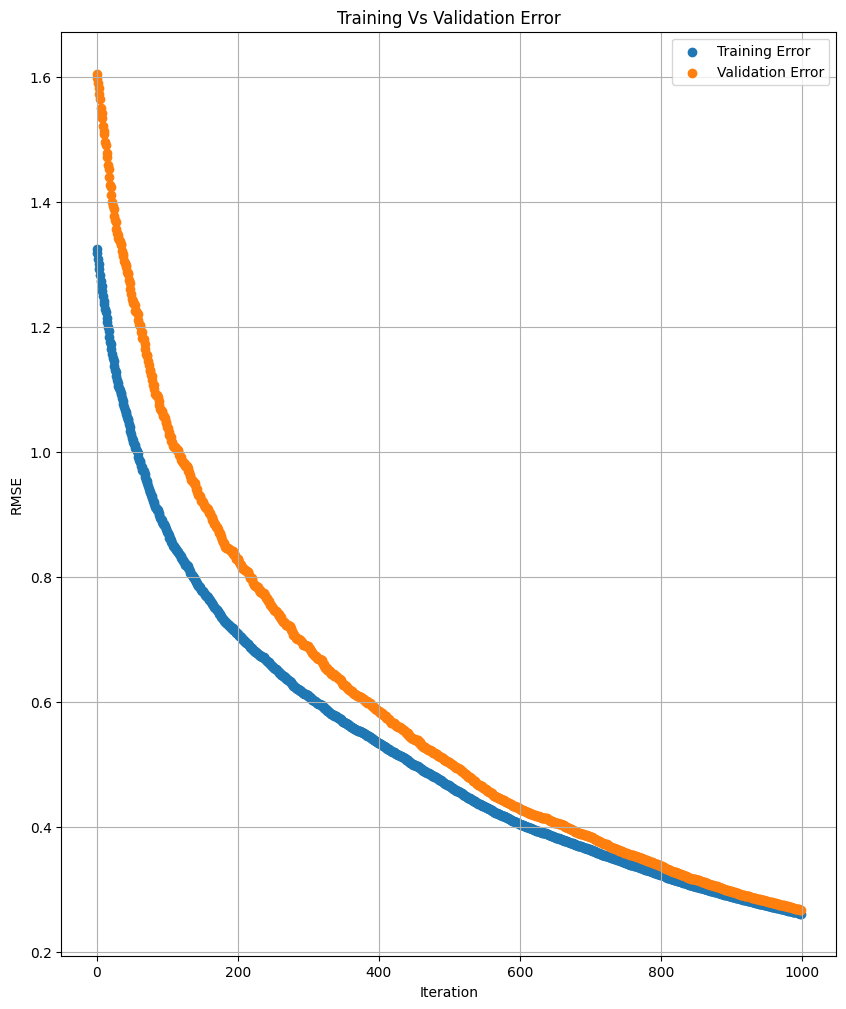

In [185]:
eval_result = rg.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))
print(training_rounds)

plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()

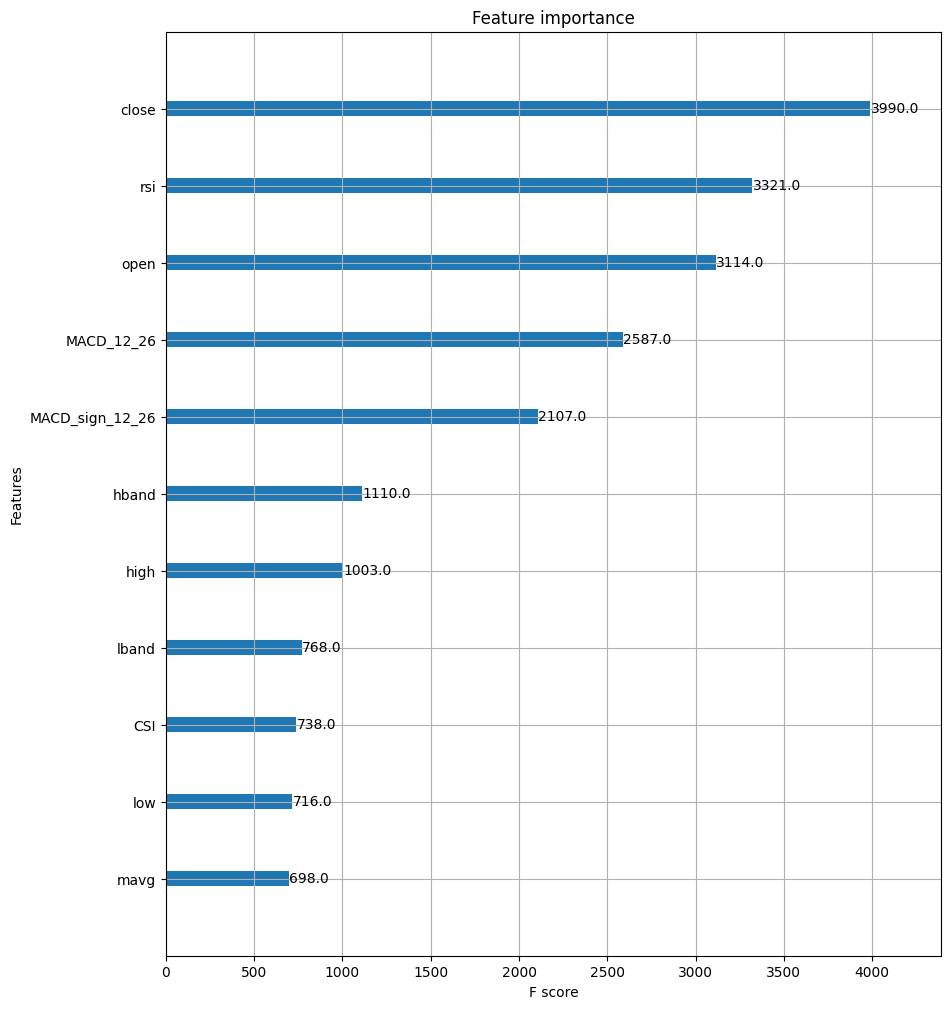

In [187]:
xgb.plot_importance(rg)
plt.show()

ValueError: ignored

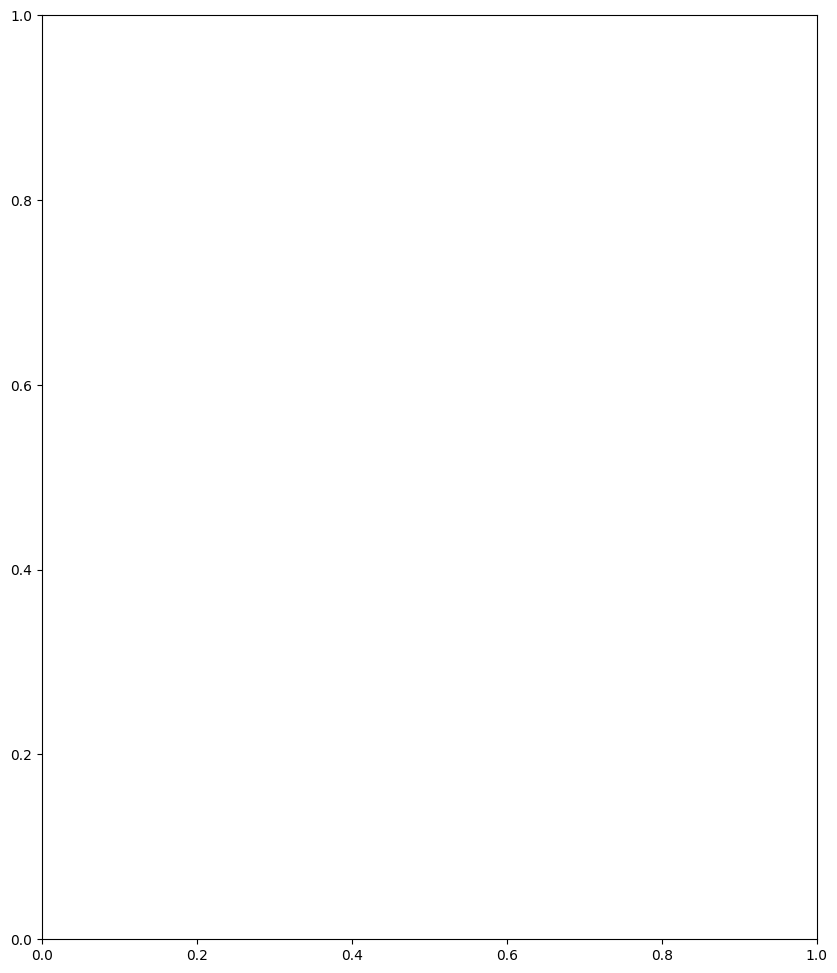

In [192]:
# Plot for entire dataset
plt.scatter(X_train, y_train,label='Target')
plt.scatter(y_train, rg.(y_test) ,label='Predicted')
plt.grid(True)
plt.xlabel('Input Feature')
plt.ylabel('Target')
plt.legend()
plt.title('XGBoost')
plt.show()

In [186]:
import joblib
# 파일명
filename = 'ks_xgb_1.model'

# 모델 저장
joblib.dump(xgb_model, open(filename, 'wb'))


# LSTM
https://pasus.tistory.com/266
https://6mini.github.io/deep%20learning/2021/10/21/NNHyperparameter/


In [65]:
raw_train.columns

Index(['close', 'open', 'high', 'low', 'rsi', 'MACD_12_26', 'MACD_sign_12_26',
       'hband', 'mavg', 'lband', 'CSI', 'target'],
      dtype='object')

In [50]:
# save original 'returns' prices for later
original_returns = raw_train['target'].values

# separate dates for future plotting
dates = pd.to_datetime(raw_train['date'])

In [67]:
# variables for training
cols = list(raw_train)[1:13]

# new dataframe with only training data - 5 columns
stock_data = raw_train[cols].astype(float)

In [68]:
cols

['open',
 'high',
 'low',
 'rsi',
 'MACD_12_26',
 'MACD_sign_12_26',
 'hband',
 'mavg',
 'lband',
 'CSI',
 'target']

In [116]:
# normalize the dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scaler = scaler.fit(stock_data)
stock_data_scaled = scaler.transform(stock_data)

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=246, random_state=123)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=248, random_state=123)

In [129]:
# split to train data and test data
n_train = 981
train_data_scaled = stock_data_scaled[0: n_train]
train_dates = dates[0: n_train]

n_validation = n_train + 248
val_data_scaled = stock_data_scaled[n_train: n_validation]
val_dates = dates[n_train: n_validation]

n_test = n_validation

test_data_scaled = stock_data_scaled[n_test:]
test_dates = dates[n_test:]

In [130]:
len(val_data_scaled)

248

In [131]:
len(test_data_scaled)

246

In [223]:
import numpy as np
# data reformatting for LSTM
pred_days = 62  # prediction period - 3months
seq_len = 62   # sequence length = past days for future prediction.
input_dim = 12  # input_dimension = ['close', 'open', 'high', 'low', 'rsi', 'MACD_12_26', 'MACD_sign_12_26', 'hband', 'mavg', 'lband', 'CSI', 'target']

trainX = []
trainY = []
valX = []
valY = []
testX = []
testY = []

for i in range(seq_len, n_train-pred_days +1):
    trainX.append(train_data_scaled[i - seq_len:i, 0:train_data_scaled.shape[1]])
    trainY.append(train_data_scaled[i + pred_days - 1:i + pred_days, 0])

for i in range(seq_len, len(val_data_scaled)-pred_days +1):
    valX.append(val_data_scaled[i - seq_len:i, 0:val_data_scaled.shape[1]])
    valY.append(val_data_scaled[i + pred_days - 1:i + pred_days, 0])

for i in range(seq_len, len(test_data_scaled)-pred_days +1):
    testX.append(test_data_scaled[i - seq_len:i, 0:test_data_scaled.shape[1]])
    testY.append(test_data_scaled[i + pred_days - 1:i + pred_days, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
valX, valY = np.array(valX), np.array(valY)
testX, testY = np.array(testX), np.array(testY)

In [224]:
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)
print(valX.shape, valY.shape)

(858, 62, 11) (858, 1)
(123, 62, 11) (123, 1)
(125, 62, 11) (125, 1)


In [227]:
!pip install keras

In [228]:
# LSTM model
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]),
               return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(trainY.shape[1]))

In [229]:
# specify your learning rate
learning_rate = 0.01
# create an Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
# compile your model using the custom optimizer
model.compile(optimizer=optimizer, loss='mse')

In [230]:
validation_data = (valX,valY)

Epoch 1/30
27/27 [==============================] - 20s 347ms/step - loss: 0.1656 - val_loss: 2.2855
Epoch 2/30
27/27 [==============================] - 4s 146ms/step - loss: 0.0971 - val_loss: 1.8083
Epoch 3/30
27/27 [==============================] - 4s 156ms/step - loss: 0.1044 - val_loss: 3.1647
Epoch 4/30
27/27 [==============================] - 6s 225ms/step - loss: 0.0947 - val_loss: 3.2559
Epoch 5/30
27/27 [==============================] - 4s 166ms/step - loss: 0.0833 - val_loss: 2.9689
Epoch 6/30
27/27 [==============================] - 4s 137ms/step - loss: 0.0792 - val_loss: 2.7269
Epoch 7/30
27/27 [==============================] - 2s 68ms/step - loss: 0.0681 - val_loss: 3.0792
Epoch 8/30
27/27 [==============================] - 3s 100ms/step - loss: 0.0903 - val_loss: 1.8900
Epoch 9/30
27/27 [==============================] - 3s 108ms/step - loss: 0.0767 - val_loss: 1.7727
Epoch 10/30
27/27 [==============================] - 2s 67ms/step - loss: 0.0840 - val_loss: 2.3225


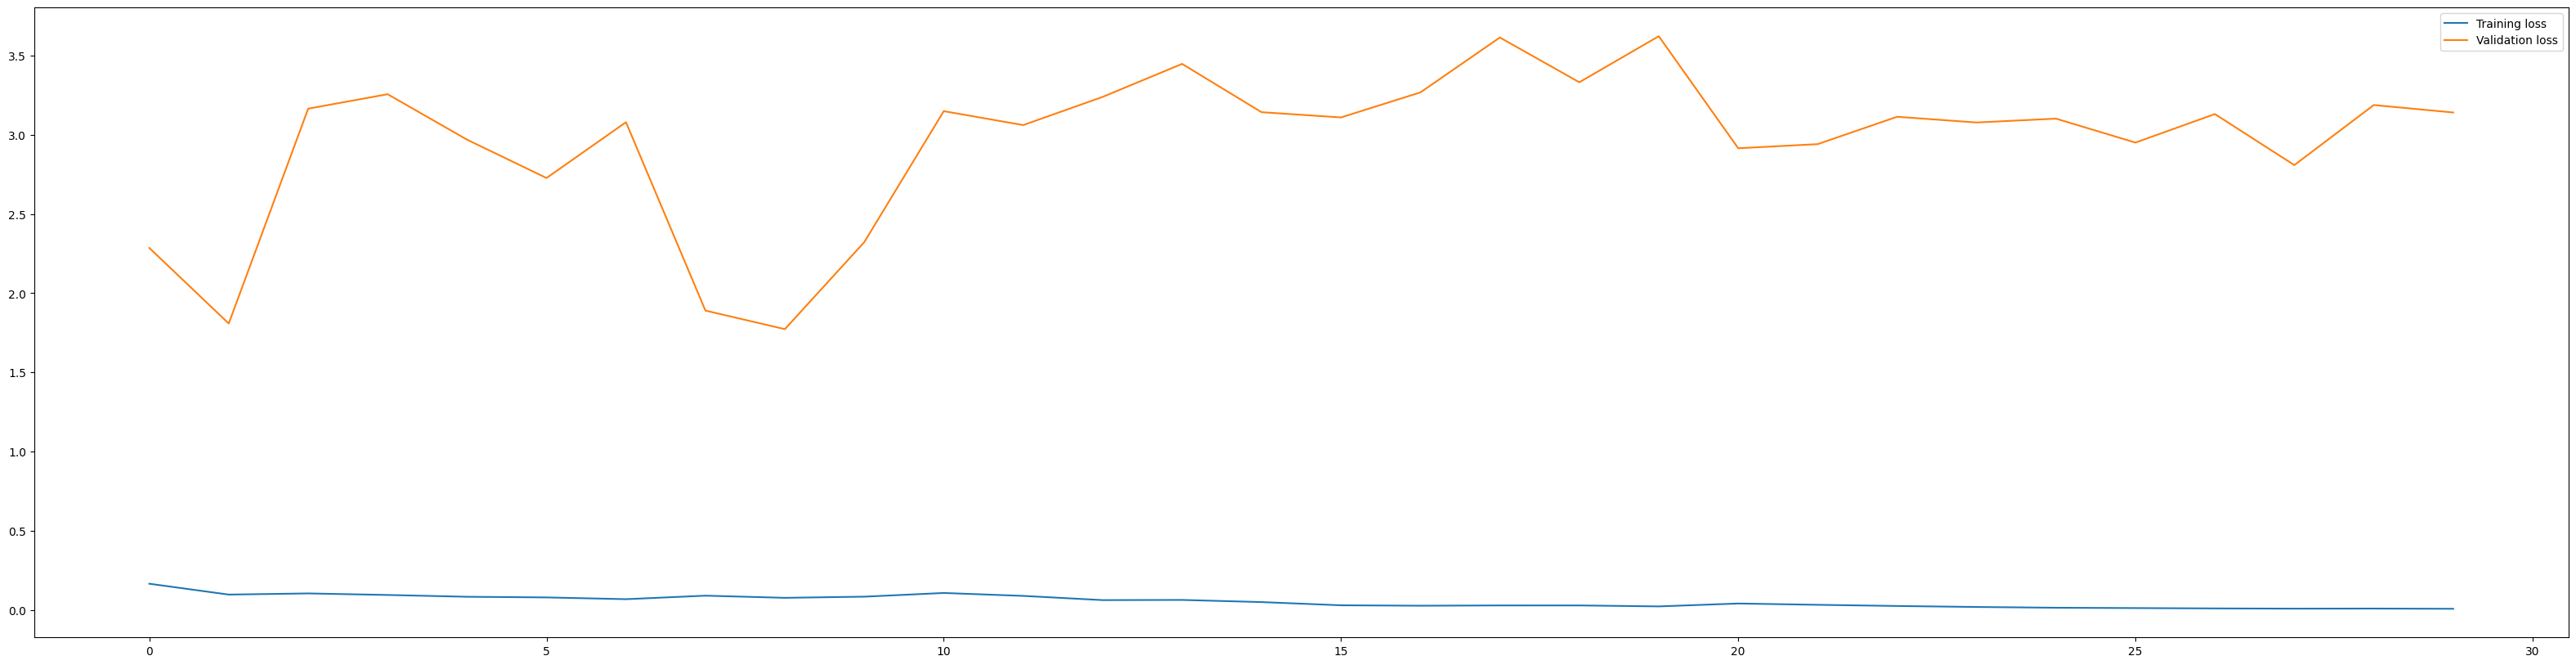

In [231]:
# import matplotlib.pyplot as plt
# try:
#     model.load_weights('./lstm_weights_2.h5')
#     print("Loaded model weights from disk")
# except:
    # Fit the model
history = model.fit(trainX, trainY, epochs=30, batch_size=32, validation_data=validation_data,
                  verbose=1)
# Save model weights after training
model.save_weights('./lstm_weights_3.h5')

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


Epoch 1/30
31/31 [==============================] - 1s 46ms/step - loss: 0.0020
Epoch 2/30
31/31 [==============================] - 1s 45ms/step - loss: 0.0015
Epoch 3/30
31/31 [==============================] - 1s 36ms/step - loss: 0.0017
Epoch 4/30
31/31 [==============================] - 1s 21ms/step - loss: 0.0019
Epoch 5/30
31/31 [==============================] - 1s 19ms/step - loss: 0.0017
Epoch 6/30
31/31 [==============================] - 1s 21ms/step - loss: 0.0016
Epoch 7/30
31/31 [==============================] - 1s 40ms/step - loss: 0.0018
Epoch 8/30
31/31 [==============================] - 1s 35ms/step - loss: 0.0015
Epoch 9/30
31/31 [==============================] - 1s 28ms/step - loss: 0.0015
Epoch 10/30
31/31 [==============================] - 1s 17ms/step - loss: 0.0015
Epoch 11/30
31/31 [==============================] - 1s 18ms/step - loss: 0.0013
Epoch 12/30
31/31 [==============================] - 1s 18ms/step - loss: 0.0013
Epoch 13/30
31/31 [==================

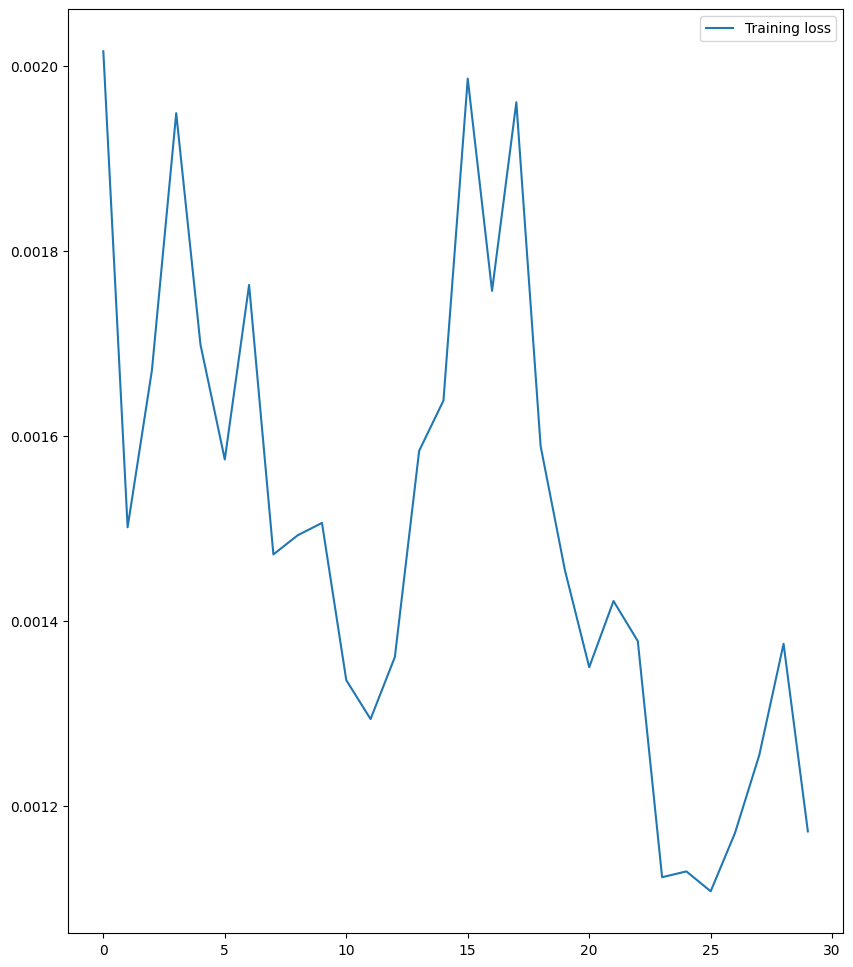

In [169]:
import matplotlib.pyplot as plt
try:
    model.load_weights('./lstm_weights_3.h5')
    print("Loaded model weights from disk")
except:
    # Fit the model
    history = model.fit(trainX, trainY, epochs=30, batch_size=32,
                     verbose=1) #validation_data
    # Save model weights after training
    model.save_weights('./lstm_weights_3.h5')

plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


In [232]:
# prediction
prediction = model.predict(testX)
print(prediction.shape, testY.shape)

4/4 [==============================] - 1s 20ms/step
(123, 1) (123, 1)


In [233]:
# generate array filled with means for prediction
mean_values_pred = np.repeat(scaler.mean_[np.newaxis, :], prediction.shape[0], axis=0)

# substitute predictions into the last column
mean_values_pred[:, -1] = np.squeeze(prediction)

# inverse transform
y_pred = scaler.inverse_transform(mean_values_pred)[:,-1]
print(y_pred.shape)


(123,)


In [234]:
# generate array filled with means for testY
mean_values_testY = np.repeat(scaler.mean_[np.newaxis, :], testY.shape[0], axis=0)

# substitute testY into the last column
mean_values_testY[:, -1] = np.squeeze(testY)
# inverse transform
testY_original = scaler.inverse_transform(mean_values_testY)[:,-1]
print(testY_original.shape)

(123,)


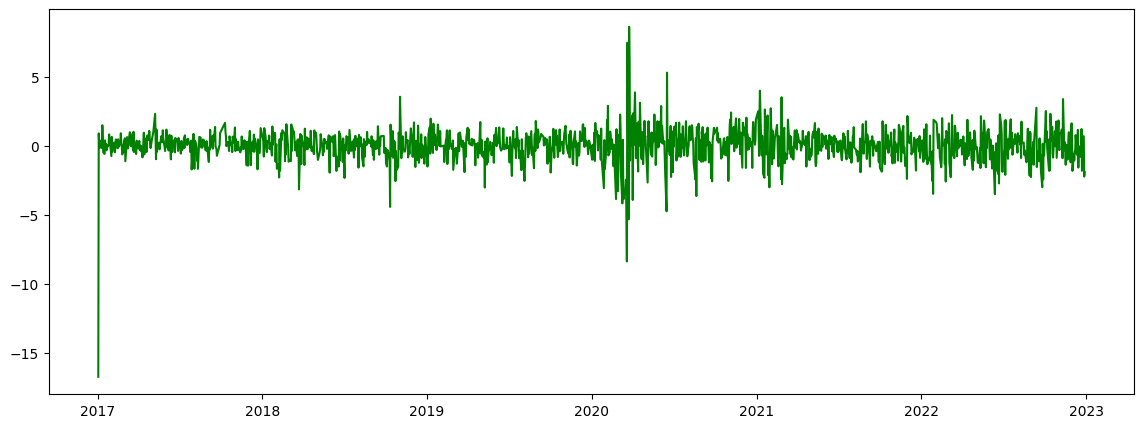

In [235]:
# plotting
plt.figure(figsize=(14, 5))

# plot original 'returns' prices
plt.plot(dates, original_returns, color='green', label='Original Returns')

In [236]:
test_dates[seq_len:]

1291   2022-04-06
1292   2022-04-07
1293   2022-04-08
1294   2022-04-11
1295   2022-04-12
          ...    
1470   2022-12-23
1471   2022-12-26
1472   2022-12-27
1473   2022-12-28
1474   2022-12-29
Name: date, Length: 184, dtype: datetime64[ns]

In [237]:
testY_original.size

123

In [ ]:
# plot actual vs predicted
plt.plot(test_dates[seq_len:], testY_original, color='blue', label='Actual Returns')
plt.plot(test_dates[seq_len:], y_pred, color='red', linestyle='--', label='Predicted Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Original, Actual and Predicted Returns')
plt.legend()
plt.show()

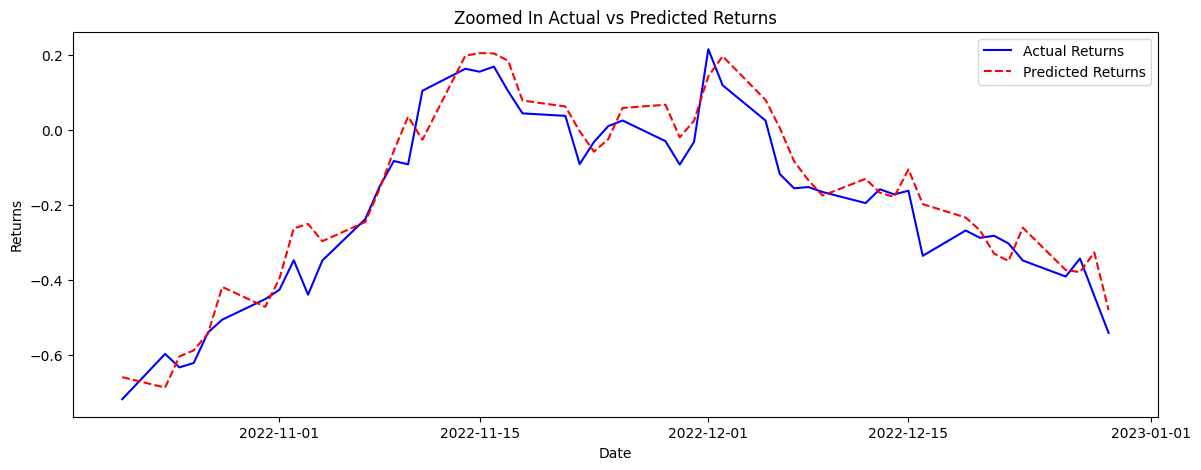

In [155]:
# Calculate the start and end indices for the zoomed plot
zoom_start = len(test_dates) - 50
zoom_end = len(test_dates)

# Create the zoomed plot
plt.figure(figsize=(14, 5))

# Adjust the start index for the testY_original and y_pred arrays
adjusted_start = zoom_start - seq_len

plt.plot(test_dates[zoom_start:zoom_end],
         testY_original[adjusted_start:zoom_end - zoom_start + adjusted_start],
         color='blue',
         label='Actual Returns')

plt.plot(test_dates[zoom_start:zoom_end],
         y_pred[adjusted_start:zoom_end - zoom_start + adjusted_start ],
         color='red',
         linestyle='--',
         label='Predicted Returns')

plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Zoomed In Actual vs Predicted Returns')
plt.legend()
plt.show()

In [156]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(testY_original, y_pred))
print("RMSE: %f" % (rmse))
# RMSE: 0.160966 ..?gg

RMSE: 0.160966


In [157]:
model.save('ks_lstm.h5')

#추가적으로 할일
- 상관관계가 높은 변수 제외  
다중공선성 문제를 방지
- 종속변수 정규화(xgboost)
- 앙상블 (참고: https://knowallworld.tistory.com/399)
- 3개월 후
https://dacon.io/en/competitions/official/236117/codeshare/8680?page=1&dtype=recent&ptype&fType

In [159]:
# 모델 불러오기
xgb_model = joblib.load(open(filename, 'rb'))

In [162]:
import tensorflow as tf
new_model = tf.keras.models.load_model('ks_lstm.h5')